In [1]:
import pathlib
from pathlib import Path
import os
import numpy as np
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate
import matplotlib.pyplot as plt
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following line uses the absolute path directory to read in where the training photos are saved, remember to put an 'r' in front for non-linux devices.

In [0]:
train = Path('/content/drive/My Drive/Colab Notebooks/binary_train')
test = Path('/content/drive/My Drive/Colab Notebooks/binary_test')

train_count = len(list(train.glob('*/*.jpg')))
test_count = len(list(test.glob('*/*.jpg')))

In [4]:
train_count
#test_count

418

In [0]:
CLASS_NAMES = np.array([item.name for item in train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES = list(CLASS_NAMES)
if CLASS_NAMES[0] == 'images':
    CLASS_BINARY = ['1','0']
else:
    CLASS_BINARY = ['0','1']

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 648
IMG_WIDTH = 864
INPUT_HEIGHT = 24
INPUT_WIDTH = 32

STEPS_PER_EPOCH = np.ceil(train_count/BATCH_SIZE)

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     class_mode='binary',
                                                   )


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     class_mode='binary',
                                                       )




Found 418 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'default': 0, 'images': 1}






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


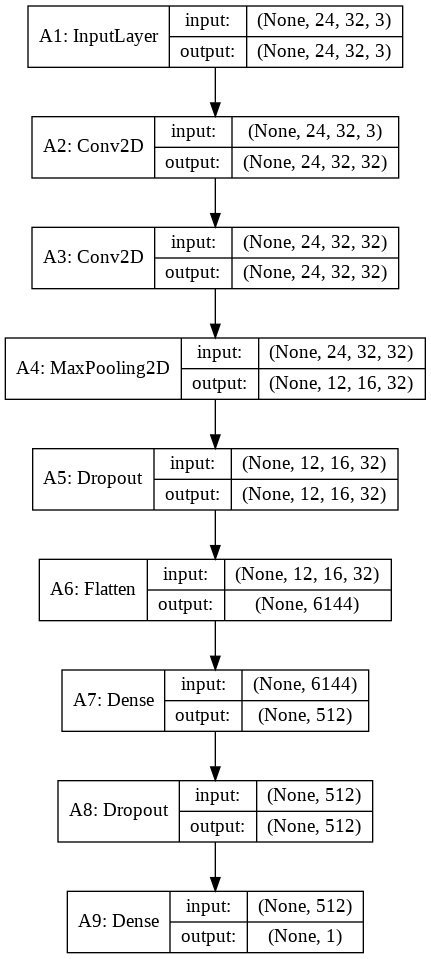

In [9]:
A1 = Input(shape=(INPUT_HEIGHT,INPUT_WIDTH,3),name='A1')
A2 = Conv2D(32, (3, 4), 
                 activation='relu', 
                 padding='same', 
                 name='A2')(A1)
A3 = Conv2D(32, (3, 4), activation='relu', padding='same',name='A3')(A2)
A4 = MaxPooling2D(pool_size=(2, 2),name='A4')(A3)
A5 = Dropout(0.25,name='A5')(A4)
A6 = Flatten(name='A6')(A5)
A7 = Dense(512, activation='relu',name='A7')(A6)
A8 = Dropout(0.2,name='A8')(A7)
A9 = Dense(1, activation='hard_sigmoid',name='A9')(A8)

model = Model(inputs=[A1],outputs=[A9])
plot_model(model,show_shapes=True)

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A1 (InputLayer)              (None, 24, 32, 3)         0         
_________________________________________________________________
A2 (Conv2D)                  (None, 24, 32, 32)        1184      
_________________________________________________________________
A3 (Conv2D)                  (None, 24, 32, 32)        12320     
_________________________________________________________________
A4 (MaxPooling2D)            (None, 12, 16, 32)        0         
_________________________________________________________________
A5 (Dropout)                 (None, 12, 16, 32)        0         
_________________________________________________________________
A6 (Flatten)                 (None, 6144)              0         
_________________________________________________________________
A7 (Dense)                   (None, 512)               3146

In [11]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
weights_multiplier = {
     0: 15.,
     1: 1.
}
epochs = 50  #instance of overfitting past epoch 35

hist = model.fit_generator(
        train_generator,
        class_weight = weights_multiplier,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
14/14 [==============================] - 6s 403ms/step - loss: 0.5228 - acc: 0.5516 - val_loss: 0.0638 - val_acc: 0.9800
Epoch 2/50
14/14 [==============================] - 5s 391ms/step - loss: 0.1570 - acc: 0.8856 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 3/50
14/14 [==============================] - 5s 363ms/step - loss: 0.0431 - acc: 0.9708 - val_loss: 6.8831e-06 - val_acc: 1.0000
Epoch 4/50
14/14 [==============================] - 5s 360ms/step - loss: 0.0221 - acc: 0.9888 - val_loss: 8.0449e-05 - val_acc: 1.0000
Epoch 5/50
14/14 [==============================] - 5s 370ms/step - loss: 0.0195 - acc: 0.9955 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/50
14/14 [==============================] - 5s 363ms/step - loss: 0.0134 - acc: 0.9933 - val_loss: 3.0517e-04 - val_acc: 1.0000
Epoch 7/50
14/14 [==============================] - 5s 370ms/step - loss: 0.0148 - acc: 0.9978 - 

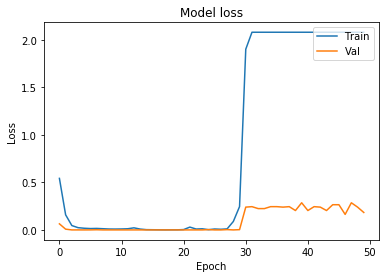

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [14]:
model.evaluate(x=validation_generator)[1]

6/6 [==============================] - 1s 99ms/step


0.7627118734990136

In [0]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (24, 32, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/drive/My Drive/Colab Notebooks/binary_test/images/10_right.jpg')
results = model.predict(image)

In [16]:
results



array([[1.]], dtype=float32)

In [0]:
#freeze model
A1.trainable = False
A2.trainable = False
A3.trainable = False
A4.trainable = False
A5.trainable = False
A6.trainable = False
A7.trainable = False
A8.trainable = False

In [18]:
train = Path('/content/drive/My Drive/Colab Notebooks/colours_train')
test = Path('/content/drive/My Drive/Colab Notebooks/colours_test')

CLASS_NAMES = np.array([item.name for item in train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES = list(CLASS_NAMES)


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes= CLASS_NAMES
                                                   )


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes= CLASS_NAMES
                                                   )




Found 360 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


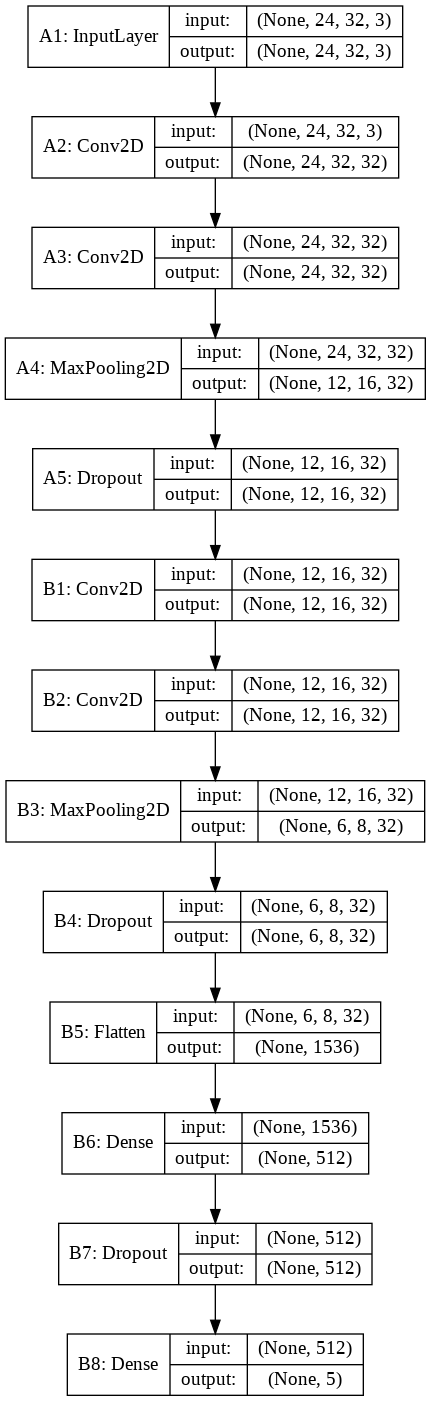

In [19]:
B1 = Conv2D(32, (3, 4), activation='relu', padding='same',name='B1')(A5)
B2 = Conv2D(32, (3, 4), activation='relu', padding='same',name='B2')(B1)
B3 = MaxPooling2D(pool_size=(2, 2),name='B3')(B2)
B4 = Dropout(0.25,name='B4')(B3)
B5 = Flatten(name='B5')(B4)
B6 = Dense(512, activation='relu',name='B6')(B5)
B7 = Dropout(0.5,name='B7')(B6)
B8 = Dense(5, activation='softmax',name='B8')(B7)
 
model = Model(inputs=[A1],outputs=[B8])
plot_model(model,show_shapes=True)


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/50
14/14 [==============================] - 6s 401ms/step - loss: 1.6312 - acc: 0.2473 - val_loss: 1.5033 - val_acc: 0.2000
Epoch 2/50
14/14 [==============================] - 5s 361ms/step - loss: 1.3852 - acc: 0.3996 - val_loss: 0.8535 - val_acc: 0.8667
Epoch 3/50
14/14 [==============================] - 5s 361ms/step - loss: 0.8395 - acc: 0.7061 - val_loss: 0.2556 - val_acc: 1.0000
Epoch 4/50
14/14 [==============================] - 5s 342ms/step - loss: 0.7779 - acc: 0.7100 - val_loss: 0.3657 - val_acc: 0.8889
Epoch 5/50
14/14 [==============================] - 5s 366ms/step - loss: 0.6644 - acc: 0.7397 - val_loss: 0.2950 - val_acc: 0.9333
Epoch 6/50
14/14 [==============================] - 5s 365ms/step - loss: 0.4080 - acc: 0.8588 - val_loss: 0.0541 - val_acc: 1.0000
Epoch 7/50
14/14 [==============================] - 5s 349ms/step - loss: 0.2782 - acc: 0.9133 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 8/50
14/14 [==============================] - 5s 374ms/step - loss: 0.

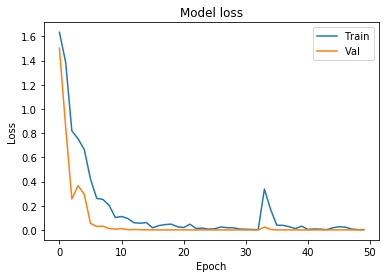

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [0]:
image = load('/content/drive/My Drive/Colab Notebooks/colours_test/green/13_middle.jpg')
results = model.predict(image)

In [24]:
CLASS_NAMES[np.argmax(results)]


'green'

In [0]:
#freeze model
B1.trainable = False
B2.trainable = False
B3.trainable = False
B4.trainable = False
B5.trainable = False
B6.trainable = False
B7.trainable = False
B8.trainable = False

In [26]:
train = Path('/content/drive/My Drive/Colab Notebooks/train')
test = Path('/content/drive/My Drive/Colab Notebooks/test')

CLASS_NAMES = np.array([item.name for item in train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES = list(CLASS_NAMES)
CLASS_NAMES = ['14',
 '13',
 '10',
 '12',
 '1',
 '3',
 '11',
 '2',
 '15',
 '4',
 '5',
 '6',
 '9',
 '7',
 '8']

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes= CLASS_NAMES
                                                   )


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes= CLASS_NAMES
                                                   )




Found 360 images belonging to 15 classes.
Found 45 images belonging to 15 classes.


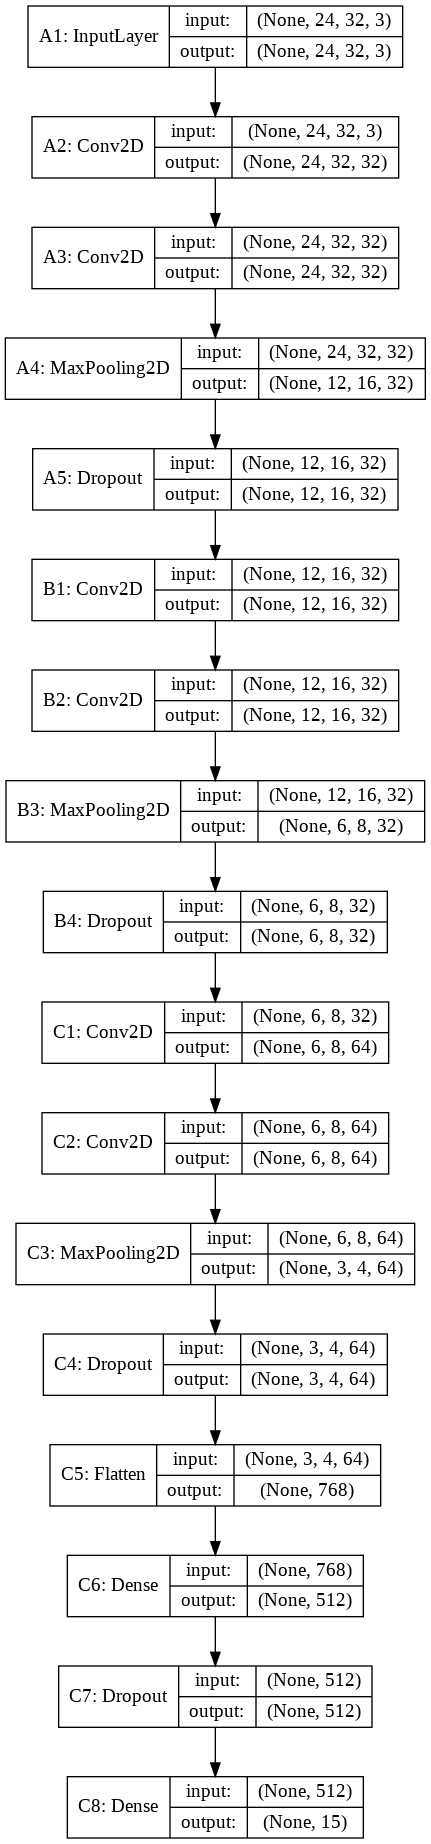

In [27]:
C1 = Conv2D(64, (3, 4), activation='relu', padding='same',name='C1')(B4)
C2 = Conv2D(64, (3, 4), activation='relu', padding='same',name='C2')(C1)
C3 = MaxPooling2D(pool_size=(2, 2),name='C3')(C2)
C4 = Dropout(0.25,name='C4')(C3)
C5 = Flatten(name='C5')(C4)
C6 = Dense(512, activation='relu',name='C6')(C5)
C7 = Dropout(0.5,name='C7')(C6)
C8 = Dense(15, activation='softmax',name='C8')(C7)

 
model = Model(inputs=[A1],outputs=[C8])
plot_model(model,show_shapes=True)




In [28]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A1 (InputLayer)              (None, 24, 32, 3)         0         
_________________________________________________________________
A2 (Conv2D)                  (None, 24, 32, 32)        1184      
_________________________________________________________________
A3 (Conv2D)                  (None, 24, 32, 32)        12320     
_________________________________________________________________
A4 (MaxPooling2D)            (None, 12, 16, 32)        0         
_________________________________________________________________
A5 (Dropout)                 (None, 12, 16, 32)        0         
_________________________________________________________________
B1 (Conv2D)                  (None, 12, 16, 32)        12320     
_________________________________________________________________
B2 (Conv2D)                  (None, 12, 16, 32)        1232

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/50
14/14 [==============================] - 6s 425ms/step - loss: 2.6040 - acc: 0.1228 - val_loss: 2.1131 - val_acc: 0.3778
Epoch 2/50
14/14 [==============================] - 5s 382ms/step - loss: 1.8813 - acc: 0.3212 - val_loss: 1.1391 - val_acc: 0.4222
Epoch 3/50
14/14 [==============================] - 5s 386ms/step - loss: 1.5649 - acc: 0.3974 - val_loss: 0.9341 - val_acc: 0.5556
Epoch 4/50
14/14 [==============================] - 5s 372ms/step - loss: 1.2787 - acc: 0.4705 - val_loss: 0.7715 - val_acc: 0.7333
Epoch 5/50
14/14 [==============================] - 5s 392ms/step - loss: 1.1802 - acc: 0.4915 - val_loss: 0.5082 - val_acc: 0.8444
Epoch 6/50
14/14 [==============================] - 5s 386ms/step - loss: 0.9058 - acc: 0.6285 - val_loss: 0.3560 - val_acc: 0.9333
Epoch 7/50
14/14 [==============================] - 6s 397ms/step - loss: 0.8691 - acc: 0.6783 - val_loss: 0.3035 - val_acc: 0.9556
Epoch 8/50
14/14 [==============================] - 5s 391ms/step - loss: 0.

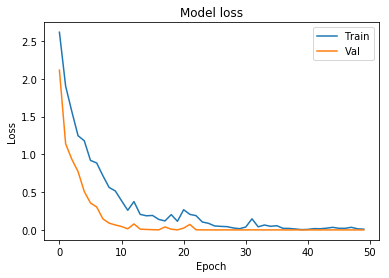

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [32]:
model.evaluate(x=validation_generator)[1]

5/5 [==============================] - 0s 93ms/step


1.0

In [0]:
image = load('/content/drive/My Drive/Colab Notebooks/test/13/5_middle.jpg')
results = model.predict(image)

In [34]:
CLASS_NAMES[np.argmax(results)]


'13'

In [0]:
C1.trainable = False
C2.trainable = False
C3.trainable = False
C4.trainable = False
C5.trainable = False
C6.trainable = False
C7.trainable = False
C8.trainable = False

In [36]:
train = Path('/content/drive/My Drive/Colab Notebooks/train')
test = Path('/content/drive/My Drive/Colab Notebooks/test')

CLASS_NAMES = np.array([item.name for item in train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES = list(CLASS_NAMES)


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes= CLASS_NAMES
                                                   )


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     classes= CLASS_NAMES
                                                   )



Found 418 images belonging to 16 classes.
Found 59 images belonging to 16 classes.


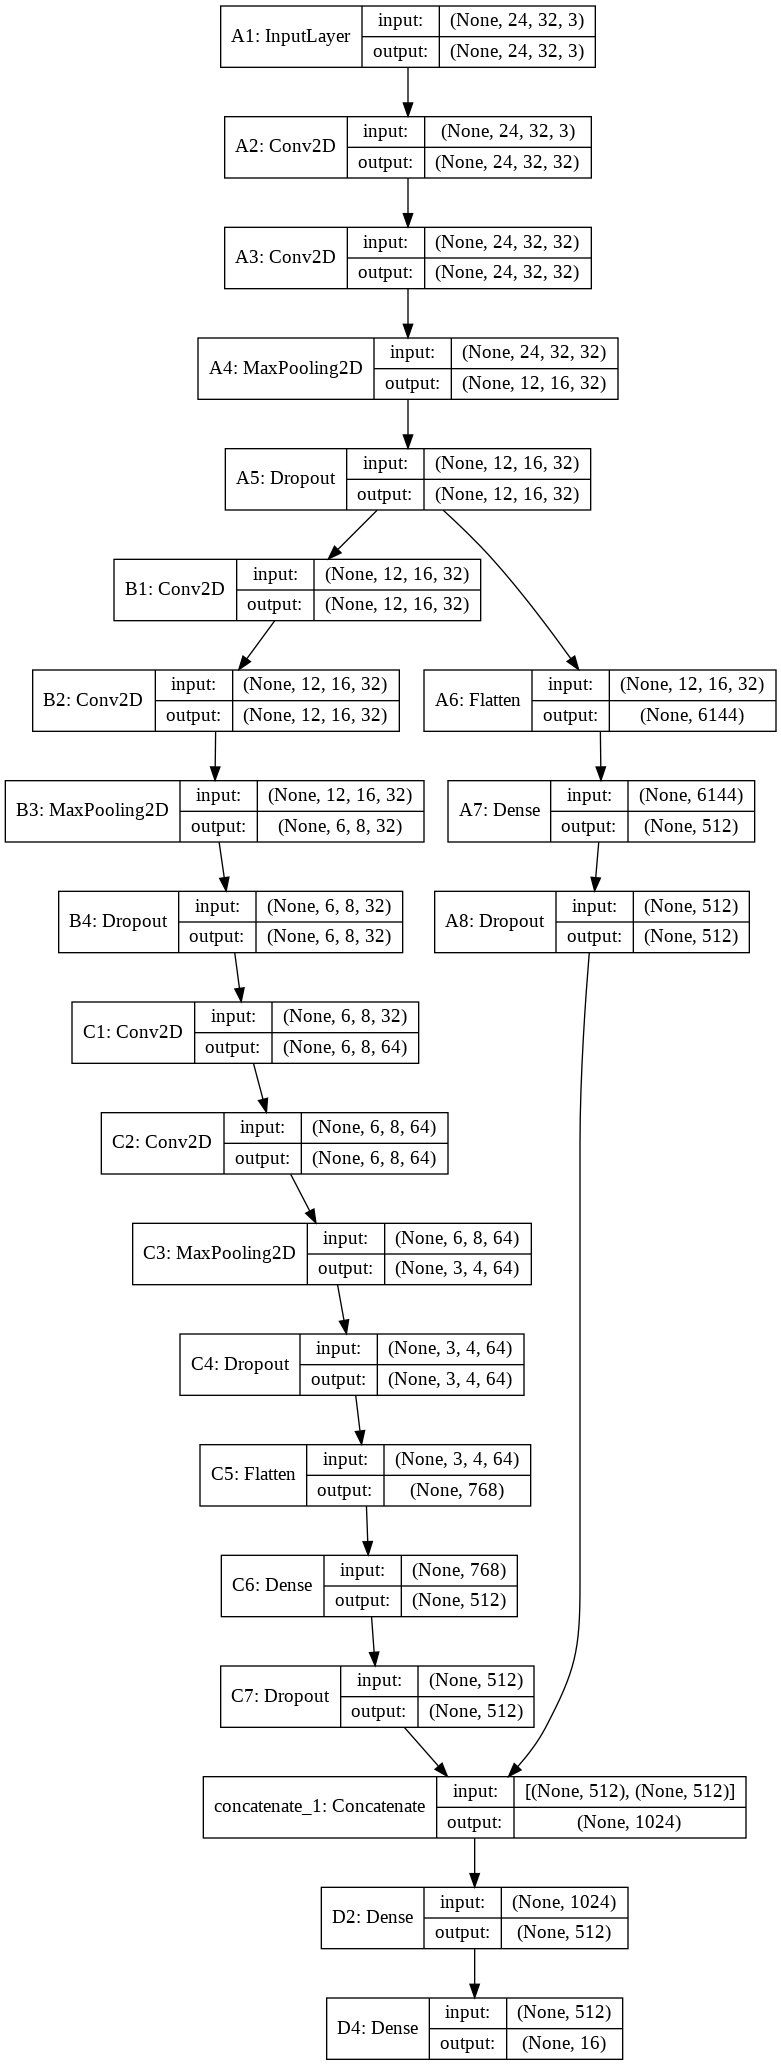

In [37]:
D1 = Concatenate(axis=1)([C7, A8])              #check if trainable
D2 = Dense(512, activation='relu',name='D2')(D1)
#D3 = Dropout(0.3,name='D3')(D2)
D4 = Dense(16, activation='softmax',name='D4')(D2)

model = Model(inputs=[A1],outputs=[D4])
plot_model(model,show_shapes=True)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [0]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/50
14/14 [==============================] - 7s 482ms/step - loss: 15.2505 - acc: 0.0538 - val_loss: 15.4734 - val_acc: 0.0400
Epoch 2/50
14/14 [==============================] - 6s 445ms/step - loss: 15.2505 - acc: 0.0538 - val_loss: 15.1313 - val_acc: 0.0612
Epoch 3/50
14/14 [==============================] - 6s 434ms/step - loss: 15.2505 - acc: 0.0538 - val_loss: 15.1313 - val_acc: 0.0612
Epoch 4/50
14/14 [==============================] - 6s 410ms/step - loss: 15.2505 - acc: 0.0538 - val_loss: 15.1313 - val_acc: 0.0612
Epoch 5/50
14/14 [==============================] - 6s 425ms/step - loss: 15.2505 - acc: 0.0538 - val_loss: 15.7892 - val_acc: 0.0204
Epoch 6/50
14/14 [==============================] - 6s 425ms/step - loss: 14.7468 - acc: 0.0851 - val_loss: 15.1313 - val_acc: 0.0612
Epoch 7/50
14/14 [==============================] - 6s 436ms/step - loss: 15.2505 - acc: 0.0538 - val_loss: 15.4734 - val_acc: 0.0400
Epoch 8/50
14/14 [==============================] - 6s 448ms/s

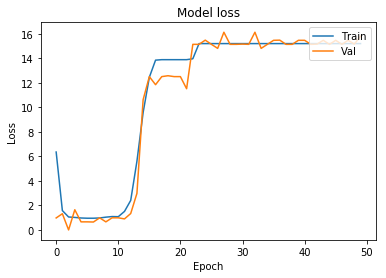

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/mymodel2.h5')

From this point onwards, refer to https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata under "load using tf.data" to be able to load the dataset in keras. 